In [221]:
# Import Source - JT - Justine Winata

from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
from pyspark.sql.functions import monotonically_increasing_id as mi
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import when
from pyspark.ml.feature  import VectorAssembler, StandardScaler

spark = SparkSession.builder.getOrCreate()


In [238]:
# Data Frame Train

from pyspark.ml.feature  import VectorAssembler, StandardScaler

df_train = spark.read.option("inferSchema", "true").csv("births.csv", header= True)
df_train = df_train.select("INFANT_SEX", "STEROIDS", "ANTIBIOTICS", "ANESTHESIA","APGAR_10",
                          "CIG_BEFORE", "MOTHER_DELIVERY_WEIGHT", "MOTHER_BMI_RECODE")

df_train = df_train.na.drop()


df_train = df_train.withColumn("INFANT_SEX", when(df_train["INFANT_SEX"] == "F", 0).\
                                                  when(df_train["INFANT_SEX"] == "M", 1))
df_train = df_train.withColumn("STEROIDS", when(df_train["STEROIDS"] == "N", 0).\
                                           when(df_train["STEROIDS"] == "U", 2).\
                                                  when(df_train["STEROIDS"] == "Y", 1))
df_train = df_train.withColumn("ANTIBIOTICS", when(df_train["ANTIBIOTICS"] == "N", 0).\
                                              when(df_train["ANTIBIOTICS"] == "U", 2).\
                                                  when(df_train["ANTIBIOTICS"] == "Y", 1))
df_train = df_train.withColumn("ANESTHESIA", when(df_train["ANESTHESIA"] == "N", 0).\
                                             when(df_train["ANESTHESIA"] == "U", 2).\
                                                  when(df_train["ANESTHESIA"] == "Y", 1))

cols = df_train.columns
df_train = VectorAssembler(inputCols = cols, outputCol = "Feature").transform(df_train)
df_train = StandardScaler(inputCol = "Feature", outputCol = "features").fit(df_train).transform(df_train)
                                                 

45429


In [239]:
# Data Frame Test
df_test = spark.read.option("inferSchema", "true").csv("births.csv", header= True)

df_test = df_test.select("INFANT_ALIVE_AT_REPORT", "INFANT_SEX", "STEROIDS", "ANTIBIOTICS", "ANESTHESIA", "APGAR_10",
                        "CIG_BEFORE", "MOTHER_DELIVERY_WEIGHT", "MOTHER_BMI_RECODE")

df_test = df_test.na.drop()

df_test = df_test.withColumn("INFANT_SEX", when(df_test["INFANT_SEX"] == "F", 0).\
                                                  when(df_test["INFANT_SEX"] == "M", 1))

df_test = df_test.withColumn("STEROIDS", when(df_test["STEROIDS"] == "N", 0).\
                                           when(df_test["STEROIDS"] == "U", 2).\
                                                  when(df_test["STEROIDS"] == "Y", 1))

df_test = df_test.withColumn("ANTIBIOTICS", when(df_test["ANTIBIOTICS"] == "N", 0).\
                                              when(df_test["ANTIBIOTICS"] == "U", 2).\
                                                  when(df_test["ANTIBIOTICS"] == "Y", 1))

df_test = df_test.withColumn("ANESTHESIA", when(df_test["ANESTHESIA"] == "N", 0).\
                                             when(df_test["ANESTHESIA"] == "U", 2).\
                                                  when(df_test["ANESTHESIA"] == "Y", 1))

df_test = df_test.withColumn("INFANT_ALIVE_AT_REPORT", when(df_test["INFANT_ALIVE_AT_REPORT"] == "N", 0).\
                                                  when(df_test["INFANT_ALIVE_AT_REPORT"] == "Y", 1))

cols = df_test.columns
cols.remove("INFANT_ALIVE_AT_REPORT")

df_test = VectorAssembler(inputCols = cols, outputCol = "Feature").transform(df_test)
df_test = StandardScaler(inputCol = "Feature", outputCol = "features").fit(df_test).transform(df_test)
                                                     

In [299]:
# Make Prediction
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_train)
prediction = model.transform(df_test)

from matplotlib import pyplot as plt 
prediction = prediction.toPandas()

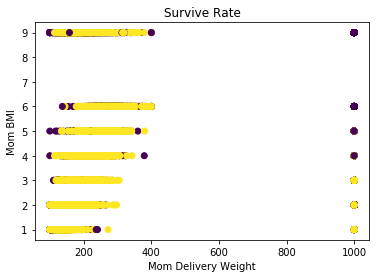

Black : Died
Yellow : Alive


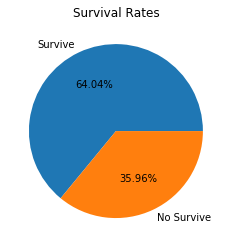

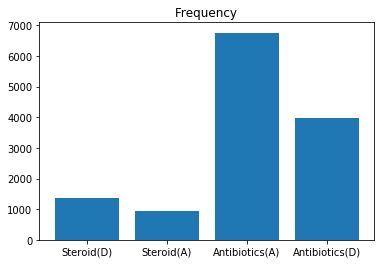

In [305]:
# Prediction Vizualiation
plt.scatter(prediction["MOTHER_DELIVERY_WEIGHT"], prediction["MOTHER_BMI_RECODE"], c = prediction["prediction"])
plt.xlabel("Mom Delivery Weight")
plt.ylabel("Mom BMI")
plt.title("Survive Rate")


plt.show()
print("Black : Died")
print("Yellow : Alive")

steroid_death = 0
steroid_alive = 0
antibiotics_death = 0
antibiotics_alive = 0

survive = 0
not_survive = 0

for index, row in prediction.iterrows():
    if row['prediction'] == 1:
#         Survive
        survive += 1
        if row['ANTIBIOTICS'] == 1 :
            antibiotics_alive += 1
        if row['STEROIDS'] == 1:
            steroid_alive += 1
    else:
#         Not Survive
        not_survive += 1
        if row['ANTIBIOTICS'] == 1 :
            antibiotics_death += 1
        if row['STEROIDS'] == 1:
            steroid_death += 1
            
amount = [survive, not_survive]
title = ["Survive", "No Survive"]
plt.title("Survival Rates")
plt.pie(amount, labels=title, autopct = "%.2f%%")
plt.show()

amount = [steroid_death, steroid_alive, antibiotics_alive, antibiotics_death]
title = ["Steroid(D)", "Steroid(A)", "Antibiotics(A)", "Antibiotics(D)"]
plt.bar(title, amount)
plt.title("Frequency")
plt.show()



In [297]:
# Prediction Accuracy
counter = 0
for index, row in prediction.iterrows():
    if row['INFANT_ALIVE_AT_REPORT'] == row['prediction']:
        counter = counter +  1
        
prediction = counter / len(prediction) * 100
print('Prediction Accuracy: ', prediction)

Prediction Accuracy:  84.16209909969403
